In [20]:
import numpy as np
import numpy.random as rd
import pandas as pd
import os
import sys
import datetime
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [21]:
cwd = os.getcwd()

dt = datetime.datetime.now()
tday = "{0:%Y%m%d%H%M}".format(dt)

experiment_id = "particle_filter" + tday
os.mkdir(experiment_id)
os.mkdir(experiment_id + "\\CKPT")
os.mkdir(experiment_id + "\\DATA")
save_stats_path = cwd + "\\" + experiment_id +"\\STATS\\"
save_data_path = cwd + "\\" + experiment_id +"\\DATA\\"

FileExistsError: [WinError 183] 既に存在するファイルを作成することはできません。: 'particle_filter201910291838'

In [27]:
class NoisyDataProcesser():
    def __init__(self, alpha_2, sigma_2, mu,length, state_dim=1):
        self.alpha_2 = alpha_2
        self.sigma_2 = sigma_2
        self.mu = mu
        self.length = length
        self.state_dim = state_dim
    def process(self, path):
        x = []
        y = []
        list_sigma_2 = []
        list_mu = []
        x.append(rd.normal(0, np.sqrt(self.alpha_2), self.state_dim))
        y.append(x[0] + rd.normal(self.mu, np.sqrt(self.sigma_2), self.state_dim))
        list_sigma_2.append(self.sigma_2)
        list_mu.append(self.mu)
        for t in range(self.length):
#             if t == 50: 
#                 self.sigma_2 = 18.0
#                 self.mu = -5
#             elif t == 100:
#                 self.mu = 13
            self.mu += 0.02
            x.append(x[t] + rd.normal(0, np.sqrt(self.alpha_2), self.state_dim))
            y.append(x[t+1] + rd.normal(self.mu, np.sqrt(self.sigma_2), self.state_dim))
            list_sigma_2.append(self.sigma_2)
            list_mu.append(self.mu)
        print(x)
        x = np.array(x)
        y = np.array(y)
        print(x.shape)
        list_sigma_2 = np.array(list_sigma_2)
        list_mu = np.array(list_mu)
        np.savetxt(path + "noisy_obs.txt", y)
        np.savetxt(path + "truth_obs.txt", x)
        np.savetxt(path + "sigma_2.txt", list_sigma_2)
        np.savetxt(path + "mu.txt", list_mu)

In [28]:
class ParticleFilter(object):
    def __init__(self, y, x_truth, n_particle, sigma_2, alpha_2, mu):
        self.y = y
        self.x_truth = x_truth
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.mu = mu
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2, mu):
        l = (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-(x+mu))**2/(2*s2))
        if np.isnan(l):
            print("Nan!! y:{},x:{},s2:{}, mu:{}".format(y,x,s2,mu))
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-(x+mu))**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                # if for all i w_cumsum[i] >= u then:
                return 0
            # if there exsist i such that w_cumsum[i] < u then:
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k

    def reresampling(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle, 3))
        x_resampled = np.zeros((T+1, self.n_particle, 3))
        
        # 潜在変数の初期値
        initial_x = rd.normal(0, 1, size=self.n_particle)
#         initial_sigma_2 = rd.normal(self.sigma_2, 0.3, size=self.n_particle)
        initial_sigma_2 = rd.rand(self.n_particle) + sys.float_info.min
        initial_mu = rd.normal(self.mu, 0.3, size=self.n_particle)
        x_resampled[0][:,0] = initial_x
        x_resampled[0][:,1] = initial_sigma_2
        x_resampled[0][:,2] = initial_mu
        x[0][:,0] = initial_x
        x[0][:,1] = initial_sigma_2
        x[0][:,2] = initial_mu

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2)) # System Noise
                x[t+1, i, 0] = x_resampled[t, i, 0] + v # システムノイズの付加
                x[t+1, i, 1] = x_resampled[t, i, 1] # システムノイズの付加
                x[t+1, i, 2] = x_resampled[t, i, 2]
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i, 0], x[t+1, i, 1],x[t+1, i, 2]) # y[t]に対する各粒子の尤度
#                 print("w[t, i]:{}".format(w[t, i]))
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
#             print("t:{},w[t]:{}, np.sum(w[t]):{}, w_normed:{}".format(t, np.sort(w[t])[0:10], np.sum(w[t]),np.sort(w_normed[t])[0:10] ))
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]

            # ReResampling
            if t % 10 == 0:
                K_inherit = int(self.n_particle*0.6)
                K_new = self.n_particle - K_inherit
                if K_inherit != self.n_particle:
                    w_resampled = w_normed[t][k]


                    unsorted_max_indices = np.argpartition(-w_resampled, K_inherit)[:K_inherit]
                    x_inherit = x[t+1, unsorted_max_indices]

                    x_new = np.zeros((K_new, 3))
                    new_state_x = rd.normal(0, 1, size=K_new)
                    new_sigma_2 = 20 * rd.rand(K_new) + sys.float_info.min
                    new_mu = (10 - (-10)) * rd.rand(K_new) - 10
                    x_new[:,0] = new_state_x
                    x_new[:,1] = new_sigma_2
                    x_new[:,2] = new_mu
                    x_resampled[t+1] = np.concatenate([x_new,x_inherit])
            print("likelihood{}\n".format(l[t]), end="")
            
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        print(self.w_normed)
        return np.diag(np.dot(self.w_normed, self.x[1:,:,0].T))
        
    def draw_graph_1(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, color="b", label="observation")
        plt.plot(self.get_filtered_value(), color="g", label="mean_of_state_particles")
        plt.plot(self.x_truth, color="y",label="true_value")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,0], color="r", s=2, alpha=0.1, label="state_particle")
        
        plt.xlabel("step")
        plt.ylabel("x")
        plt.title("How particle filter works , state : sigma^2={0}, mu={1},alpha^2={2}".format(self.sigma_2, self.mu ,self.alpha_2))
        plt.savefig(save_data_path + "state_particle.png")
    def draw_graph_2(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, color="b", label="observation")
        plt.plot(self.get_filtered_value(), color="g", label="mean_of_state_particles")
        plt.plot(self.x_truth, color="y",label="true_value")
        
#         for t in range(T):
#             plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,0], color="r", s=2, alpha=0.1, label="state_particle")
        
        plt.xlabel("step")
        plt.ylabel("x")
        plt.title("How particle filter works , state : sigma^2={0}, mu={1},alpha^2={2}".format(self.sigma_2, self.mu ,self.alpha_2))
        plt.savefig(save_data_path + "state_estimate.png")
    def draw_graph_sigma_2(self, sigma_2_tru):
        
        self.sigma_2_tru = sigma_2_tru
        
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,1], color="r", s=2, alpha=0.1, label="parameter_particle")
        plt.plot(range(T), self.sigma_2_tru, color="y", label="sigma_2_tru")
        plt.xlabel("step")
        plt.ylabel("sigma_2")
        plt.title("How particle filter works , parameter: sigma^2={0}, alpha^2={1}".format(self.sigma_2, self.alpha_2))
        plt.savefig(save_data_path + "sigma_particle.png")
    def draw_graph_mu(self, mu_tru):
        
        self.mu_tru = mu_tru
        
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t][:,2], color="r", s=2, alpha=0.1, label="parameter_particle")
        plt.plot(range(T), self.mu_tru, color="y", label="sigma_2_tru")
        plt.xlabel("step")
        plt.ylabel("mum_2")
        plt.title("How particle filter works , parameter: sigma^2={0}, alpha^2={1}".format(self.sigma_2, self.alpha_2))
        plt.savefig(save_data_path + "mu_particle.png")

### パーティクルフィルターによるフィルタリング

In [29]:
# ハイパーパラメーター
params = {}
a = -2
b = -1

n_particle = 10**3 * 5
sigma_2 = 2**a
alpha_2 = 10**b
mu = -5
length = 200


params["a"] = a
params["b"] = b
params["n_particle"] = n_particle
params["sigma_2"] = sigma_2
params["alpha_2"] = alpha_2
params["mu"] = mu
params["length"] = length
import json
with open(save_data_path + "params.json", "w") as file:
    json.dump(params, file)

In [31]:
dataprocesser = NoisyDataProcesser(alpha_2, sigma_2, mu, length, 3)
dataprocesser.process(save_data_path)
noisy_obs = pd.read_csv(save_data_path + "noisy_obs.txt",header=None)
truth_obs = pd.read_csv(save_data_path + "truth_obs.txt",header=None) 
noisy_obs.columns = ["data"]
truth_obs.columns = ["data"]
sigma_2_tru = pd.read_csv(save_data_path + "sigma_2.txt",header=None)
mu_tru = pd.read_csv(save_data_path + "mu.txt",header=None) 
sigma_2_tru.columns = ["data"]
mu_tru.columns = ["data"]

[array([ 0.53372216,  0.44466683, -0.14694446]), array([ 0.25878828,  0.01581192, -0.10977127]), array([ 0.18447697,  0.47197672, -0.14774211]), array([ 0.21585937,  0.09423013, -0.34088663]), array([0.00538314, 0.46349789, 0.43297795]), array([-0.24048833,  0.38405251,  0.85248669]), array([0.04903954, 0.78890242, 0.99626483]), array([-0.72490277,  0.26775771,  0.91611549]), array([-1.43325974,  0.4684266 ,  1.05614435]), array([-1.36615222,  0.33793664,  0.97128842]), array([-1.32005593,  0.3306998 ,  1.43588002]), array([-1.39672883,  0.12473606,  1.32757982]), array([-1.29853515,  0.14741552,  1.23245098]), array([-0.9605776 ,  0.48678724,  0.9584123 ]), array([-1.15239169,  0.47125272,  0.70930702]), array([-1.05684895,  0.05537756,  0.50830892]), array([-0.91641458, -0.32525521,  0.6449532 ]), array([-1.08660152, -0.01380733,  0.66286928]), array([-0.6157125 ,  0.282716  ,  0.65748451]), array([-0.62520015, -0.34384639,  0.43148771]), array([-0.38661578, -0.40250602,  0.71297548]

In [32]:
noisy_obs.plot(figsize=(12,4))
plt.title("Test Data Noisy")
plt.savefig(save_data_path + "noisy_obs.png")

truth_obs.plot(figsize=(12,4))
plt.title("Test Data Truth")
plt.savefig(save_data_path + "truth_obs.png")

sigma_2_tru.plot(figsize=(12,4))
plt.title("sigma_2_df")
plt.savefig(save_data_path + "sigma_2_df.png")

mu_tru.plot(figsize=(12,4))
plt.title("mu_df")
plt.savefig(save_data_path + "mu_df.png")

TypeError: no numeric data to plot

In [554]:
pf = ParticleFilter(noisy_obs.data.values, truth_obs.data.values, n_particle, sigma_2, alpha_2,mu)

In [555]:
pf.simulate()

 calculating... t=0likelihood7.202829575580409
 calculating... t=1likelihood6.627020347314525
 calculating... t=2likelihood7.067804776207786
 calculating... t=3likelihood7.47048083119648
 calculating... t=4likelihood7.521689386894429
 calculating... t=5likelihood7.290277786022501
 calculating... t=6likelihood7.38624097749077
 calculating... t=7likelihood7.374040870038609
 calculating... t=8likelihood7.57683247436582
 calculating... t=9likelihood7.273890204743125
 calculating... t=10likelihood6.002549734975265
 calculating... t=11likelihood6.8856922772030895
 calculating... t=12likelihood6.113494174851961
 calculating... t=13likelihood7.114224476003611
 calculating... t=14likelihood7.560492730258063
 calculating... t=15likelihood7.069975665098396
 calculating... t=16likelihood7.627927213761361
 calculating... t=17likelihood6.934711154826723
 calculating... t=18likelihood7.621638179122131
 calculating... t=19likelihood7.673178330531241
 calculating... t=20likelihood7.718072593048725
 cal

 calculating... t=171likelihood6.94165588855271
 calculating... t=172likelihood7.145373058070272
 calculating... t=173likelihood7.665528359086376
 calculating... t=174likelihood6.816586460293484
 calculating... t=175likelihood5.666437566320827
 calculating... t=176likelihood7.695969886584412
 calculating... t=177likelihood7.274966578767102
 calculating... t=178likelihood7.5685560207262865
 calculating... t=179likelihood7.608539216399137
 calculating... t=180likelihood7.9214304914551485
 calculating... t=181likelihood7.138171311385678
 calculating... t=182likelihood7.8501243678406425
 calculating... t=183likelihood6.954047215810442
 calculating... t=184likelihood7.328118535136244
 calculating... t=185likelihood7.9846447801514575
 calculating... t=186likelihood7.041680536051
 calculating... t=187likelihood7.973138107792751
 calculating... t=188likelihood7.736010630458943
 calculating... t=189likelihood8.028491146498297
 calculating... t=190likelihood7.918554133422909
 calculating... t=19

[[2.80250202e-004 4.83713292e-008 1.60165578e-005 ... 3.88290591e-004
  4.39351760e-007 4.43816764e-005]
 [2.50742457e-009 3.56702622e-006 2.25975414e-007 ... 1.02424712e-003
  2.57451338e-016 3.55960091e-008]
 [9.49795489e-005 7.04556449e-005 9.51624481e-005 ... 3.10874006e-005
  4.71128210e-005 7.24196498e-004]
 ...
 [2.01102346e-005 5.52337598e-006 1.83975328e-005 ... 0.00000000e+000
  5.09252676e-004 3.19278794e-012]
 [3.50770938e-004 2.70209738e-004 0.00000000e+000 ... 0.00000000e+000
  3.19041754e-039 2.38831465e-111]
 [8.86242752e-017 1.92382562e-003 3.90860772e-007 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


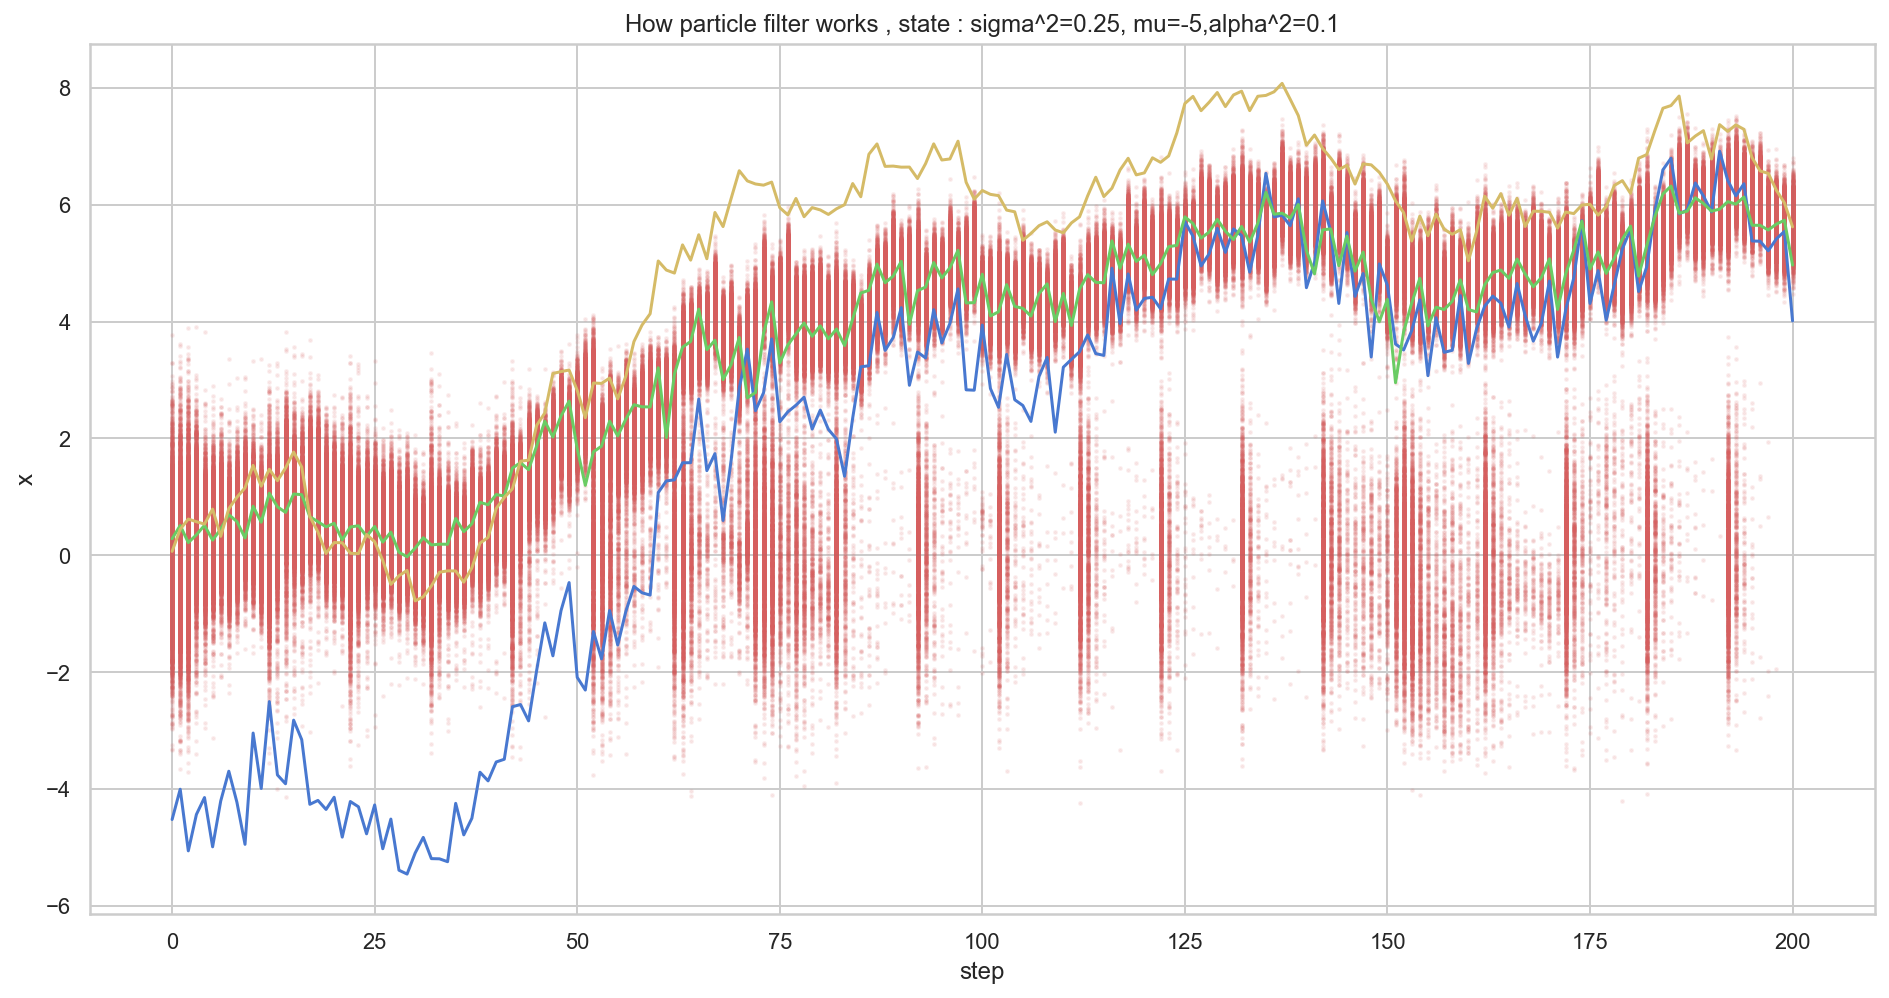

In [556]:
pf.draw_graph_1()

[[2.80250202e-004 4.83713292e-008 1.60165578e-005 ... 3.88290591e-004
  4.39351760e-007 4.43816764e-005]
 [2.50742457e-009 3.56702622e-006 2.25975414e-007 ... 1.02424712e-003
  2.57451338e-016 3.55960091e-008]
 [9.49795489e-005 7.04556449e-005 9.51624481e-005 ... 3.10874006e-005
  4.71128210e-005 7.24196498e-004]
 ...
 [2.01102346e-005 5.52337598e-006 1.83975328e-005 ... 0.00000000e+000
  5.09252676e-004 3.19278794e-012]
 [3.50770938e-004 2.70209738e-004 0.00000000e+000 ... 0.00000000e+000
  3.19041754e-039 2.38831465e-111]
 [8.86242752e-017 1.92382562e-003 3.90860772e-007 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


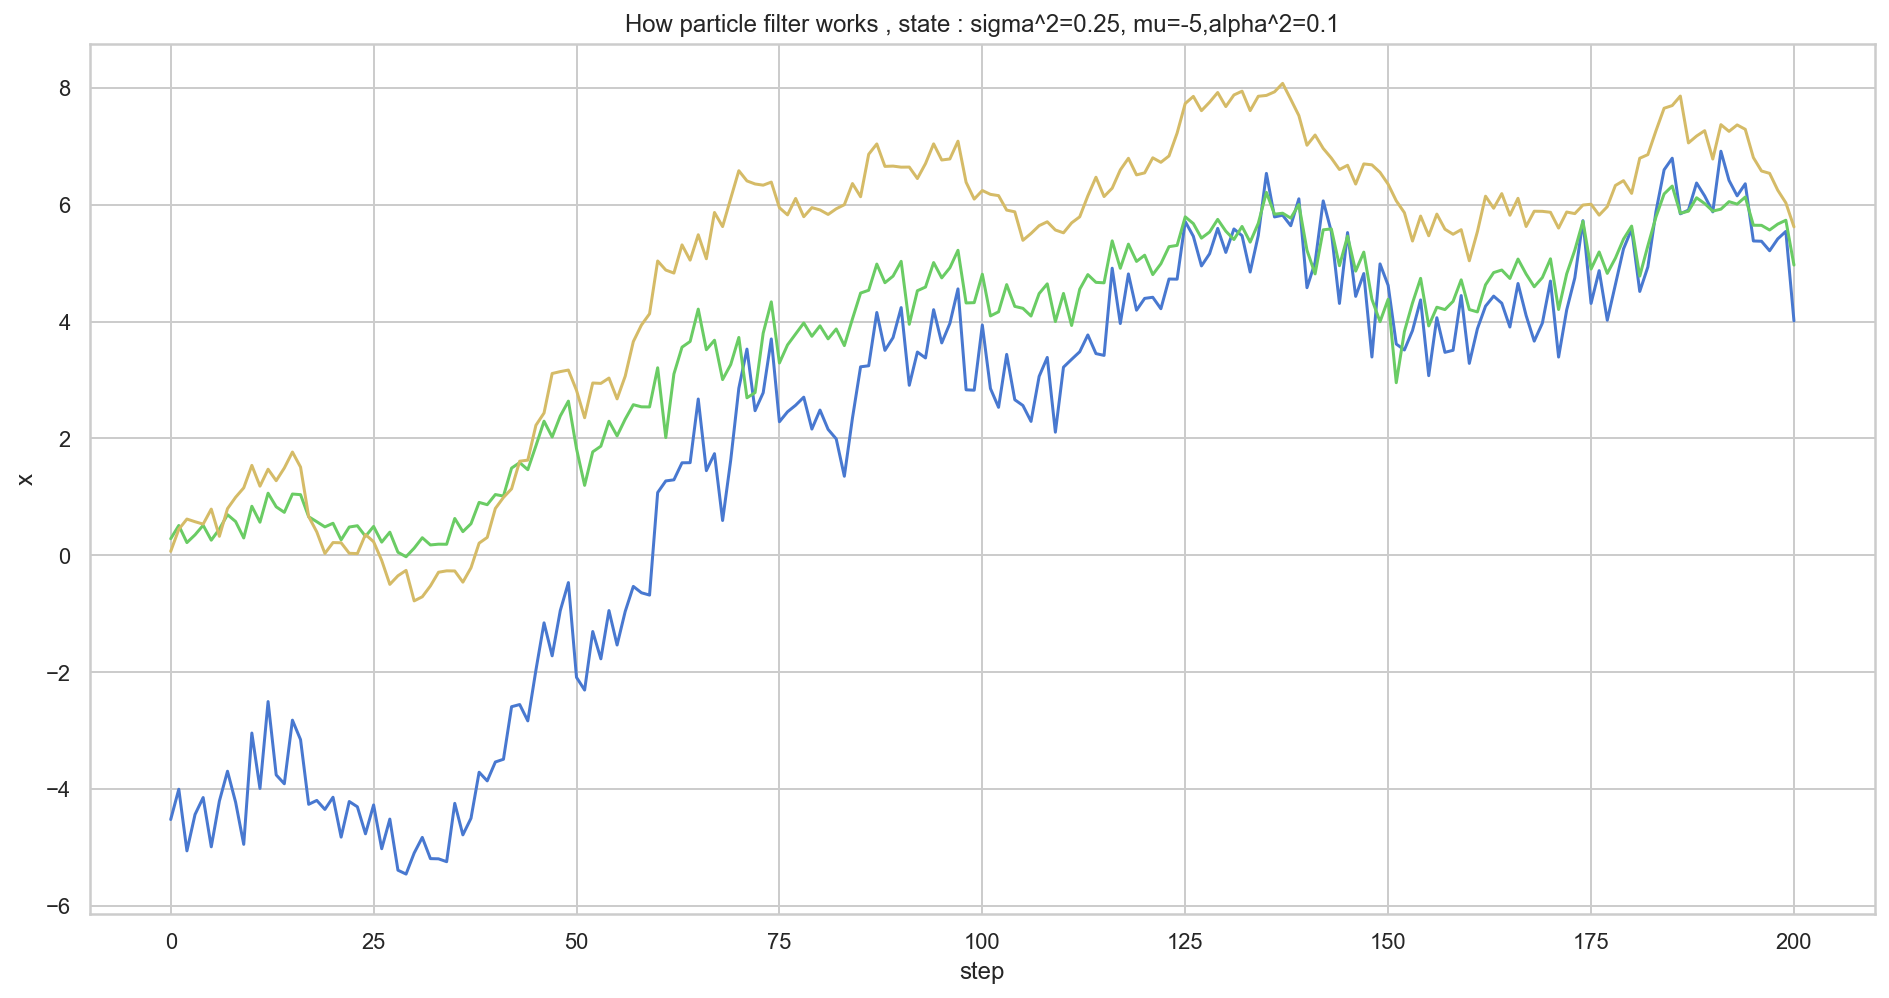

In [557]:
pf.draw_graph_2()

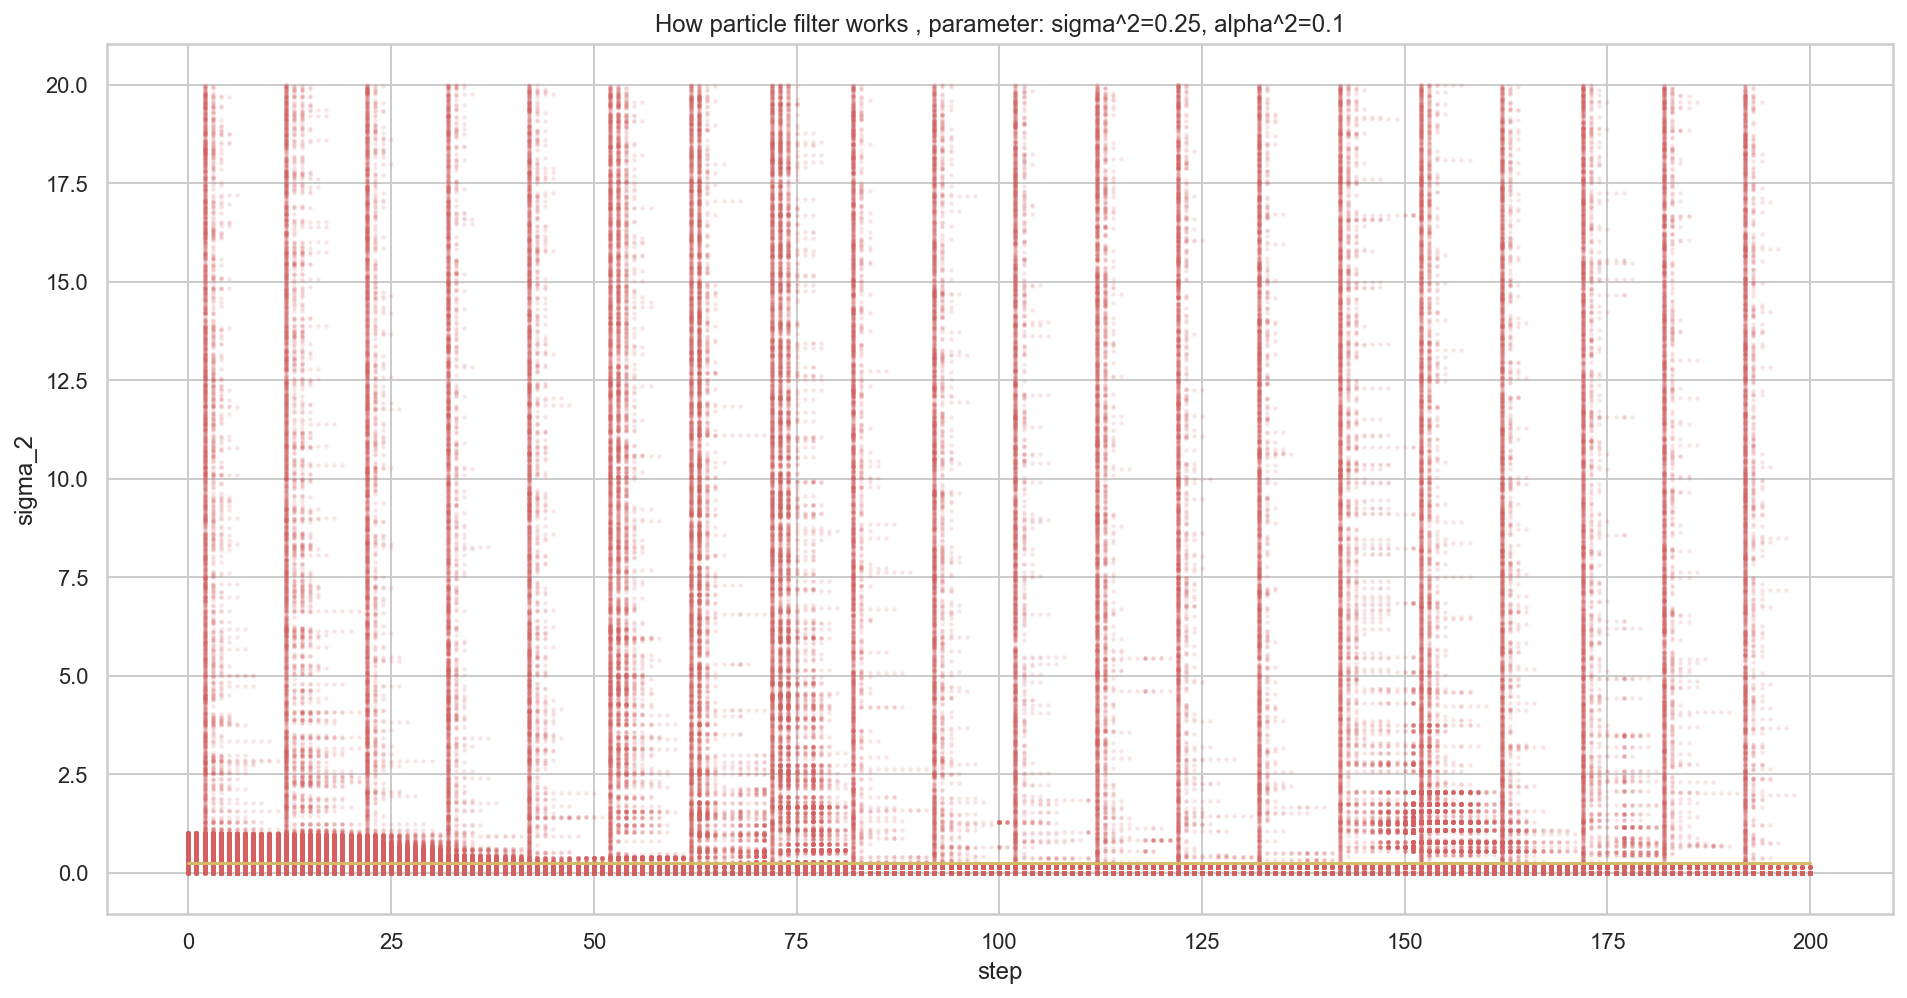

In [558]:
pf.draw_graph_sigma_2(sigma_2_tru)

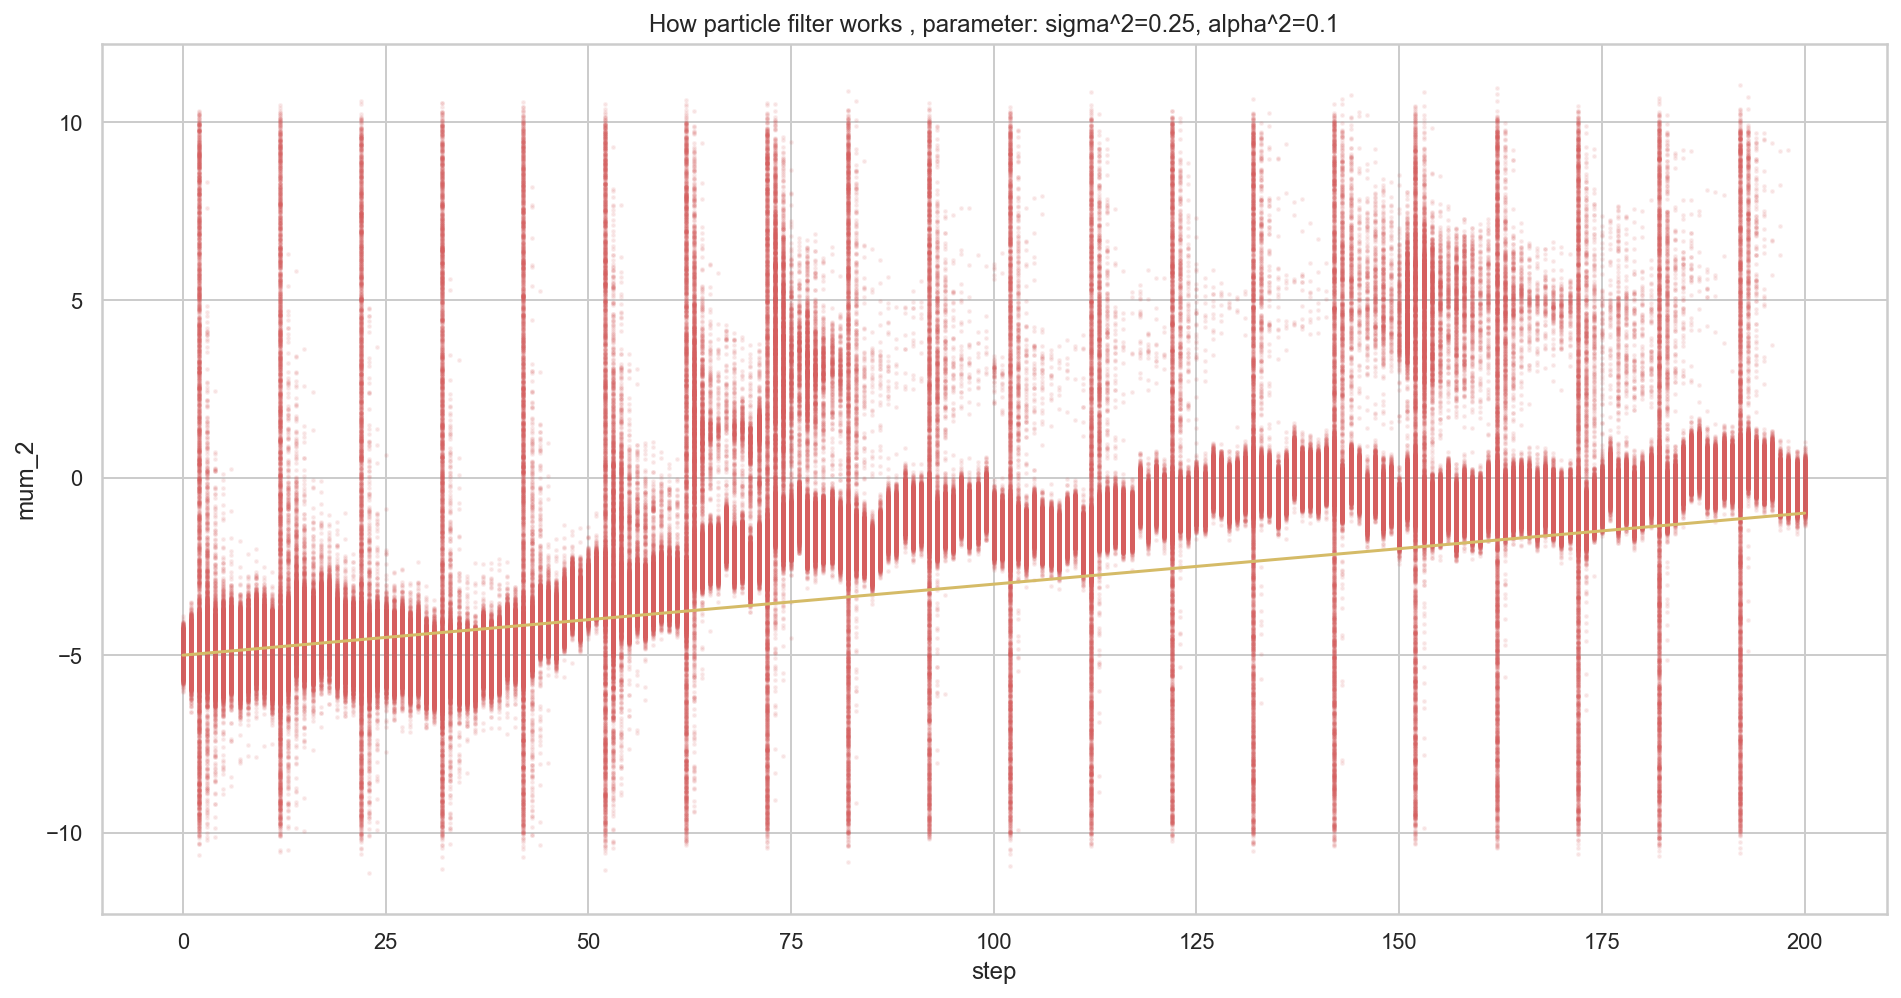

In [559]:
pf.draw_graph_mu(mu_tru)

In [13]:
idx = np.argmax(likelihood_list)
print("argmax idx:", idx)

print("likelihood={}, a:{}, b={}".format(likelihood_list[idx], a_list[idx], b_list[idx]))

argmax idx: 70
likelihood=-80.18725241309176, a:-2, b=-1


In [ ]:
n_particle = 10**3
result_list = []
a_list = []
b_list = []
likelihood_list = []

for a in range(-8, 2):
    for b in range(-5, 6):
        sigma_2 = 2**a
        alpha_2 = 10**b
        pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)
        pf.simulate()
        result_list.append(pf)
        print("")
        print(a, b, pf.log_likelihood)
        a_list.append(a)
        b_list.append(b)
        likelihood_list.append(pf.log_likelihood)